Problem Statement:
# What features are customers identifying in the category of Grocery and Gourmet Food in Amazon through their questions, and are these questions being anwered?

A Capstone project applying NLP modeling to Amazon Question and Answer banks 

by Robert Spoonmore

# Data Source:
https://jmcauley.ucsd.edu/data/amazon/qa/qa_Grocery_and_Gourmet_Food.json.gz

***Citation:***

Modeling ambiguity, subjectivity, and diverging viewpoints in opinion question answering systems
Mengting Wan, Julian McAuley
International Conference on Data Mining (ICDM), 2016

Addressing complex and subjective product-related queries with customer reviews
Julian McAuley, Alex Yang
World Wide Web (WWW), 2016

# Data Import Instructions:

***Reading the data***
Data can be treated as python dictionary objects. A simple script to read any of the above the data is as follows:

def parse(path): g = gzip.open(path, 'r') for l in g: yield eval(l)


***Convert to 'strict' json***
The above data can be read with python 'eval', but is not strict json. If you'd like to use some language other than python, you can convert the data to strict json as follows:

import json import gzip def parse(path): g = gzip.open(path, 'r') for l in g: yield json.dumps(eval(l)) f = open("output.strict", 'w') for l in parse("qa_Video_Games.json.gz"): f.write(l + '\n')


***Pandas data frame***
This code reads the data into a pandas data frame:

import pandas as pd import gzip def parse(path): g = gzip.open(path, 'rb') for l in g: yield eval(l) def getDF(path): i = 0 df = {} for d in parse(path): df[i] = d i += 1 return pd.DataFrame.from_dict(df, orient='index') df = getDF('qa_Video_Games.json.gz')

In [1]:
# special IPython command to prepare the notebook for matplotlib and other libraries
%matplotlib inline 

import json
import numpy as np
import pandas as pd
import gzip
import scipy.stats as stats
import matplotlib.pyplot as plt
import sklearn
import nltk
#import pprint
#from gensim import corpora
import re
from gensim.models import doc2vec, Word2Vec, KeyedVectors
from gensim.models.doc2vec import TaggedDocument
from gensim.parsing.preprocessing import remove_stopwords
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial import distance

In [2]:
# Define path for Amazon data
path = r'/Users/robertspoonmore/Desktop/Capstone datasets/qa_Grocery_and_Gourmet_Food.json.gz'

***Data Structure***

asin - ID of the product

questionType - type of question. Could be 'yes/no' or 'open-ended'

answerType - type of answer. Could be 'Y', 'N', or '?' (if the polarity of the answer could not be predicted). 

Only present for yes/no questions.

answerTime - raw answer timestamp

unixTime - answer timestamp converted to unix time

question - question text

answer - answer text

In [3]:
def parse(path): 
    g = gzip.open(path, 'rb') 
    for l in g: 
        yield eval(l) 
        
def getDF(path): 
    i = 0 
    df = {} 
    for d in parse(path): 
        df[i] = d 
        i += 1 
    return pd.DataFrame.from_dict(df, orient='index') 

food_df = getDF(path)

In [4]:
print("shape: ",food_df.shape,"\n")
print("columns: ",food_df.columns,"\n")
print("DF info: ",food_df.info(),"\n")
food_df.head()

shape:  (19538, 7) 

columns:  Index(['questionType', 'asin', 'answerTime', 'unixTime', 'question', 'answer',
       'answerType'],
      dtype='object') 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19538 entries, 0 to 19537
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   questionType  19538 non-null  object 
 1   asin          19538 non-null  object 
 2   answerTime    19538 non-null  object 
 3   unixTime      18930 non-null  float64
 4   question      19538 non-null  object 
 5   answer        19538 non-null  object 
 6   answerType    7294 non-null   object 
dtypes: float64(1), object(6)
memory usage: 1.2+ MB
DF info:  None 



,questionType,asin,answerTime,unixTime,question,answer,answerType
0,open-ended,9742356831,"Mar 26, 2014",1.395817e+09,What is the heat of this compared to the yello...,I think that the yellow is the most mild. The ...,NaN
1,yes/no,9742356831,"Apr 2, 2014",1.396422e+09,Is there MSG in it?,No MSG in Mae Ploy curry pastes.,N
2,open-ended,9742356831,"Apr 5, 2015",1.428217e+09,what are the ingredients exactly in this produ...,The ingredients are listed in the description!,NaN
3,open-ended,9742356831,"Aug 19, 2014",1.408432e+09,How important is the expiraci&oacute;n date on...,I never pay attention to it myself. The ingred...,NaN
4,open-ended,9742356831,"Aug 2, 2014",1.406963e+09,"The product description says 14 oz., but the p...",We bought the 14oz for just under $5.,NaN


In [5]:
# Create food dataframe holding the product id, question, and associated answer
food = food_df[['asin', 'question', 'answer']]
food.head()

,asin,question,answer
0,9742356831,What is the heat of this compared to the yello...,I think that the yellow is the most mild. The ...
1,9742356831,Is there MSG in it?,No MSG in Mae Ploy curry pastes.
2,9742356831,what are the ingredients exactly in this produ...,The ingredients are listed in the description!
3,9742356831,How important is the expiraci&oacute;n date on...,I never pay attention to it myself. The ingred...
4,9742356831,"The product description says 14 oz., but the p...",We bought the 14oz for just under $5.


In [6]:
# in viewing the df, look for missing values
print('shape: ',food.shape)
food.isna().sum()

shape:  (19538, 3)


asin        0
question    0
answer      0
dtype: int64

In [7]:
food.dtypes

asin        object
question    object
answer      object
dtype: object

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


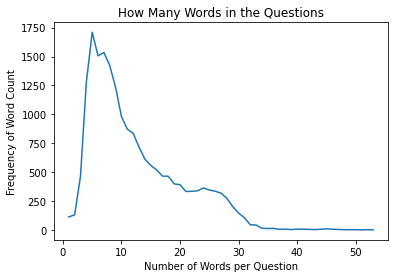

In [8]:
# Look at the word count of all the questions
food['words in question'] = food['question'].str.split().str.len()
word_count = food['words in question'].value_counts().sort_index(ascending=True)
labels = np.arange(1,len(word_count)+1,1)
plt.plot(labels,word_count)
plt.xlabel('Number of Words per Question')
plt.ylabel('Frequency of Word Count')
plt.title('How Many Words in the Questions')
plt.show()

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


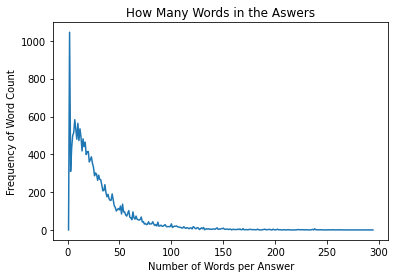

In [9]:
# Look at the word count of all the anwers
food['words in answer'] = food['answer'].str.split().str.len()
word_count = food['words in answer'].value_counts().sort_index(ascending=True)
labels = np.arange(1,len(word_count)+1,1)
plt.plot(labels,word_count)
plt.xlabel('Number of Words per Answer')
plt.ylabel('Frequency of Word Count')
plt.title('How Many Words in the Aswers')
plt.show()

In [10]:
# We must consider all answers regardless of size
# Look at the type of answers we see in the category
food['words in answer'].value_counts()
# We can see that there are 1045 answers that are only one word
one_word_answers = food[food['words in answer']==1]

# Create a series of data from the answer column
one_word_answers = one_word_answers['answer'].squeeze()
# lower case all letters
one_word_answers = one_word_answers.str.lower()
# remove periods at end of the answers - some yes show up as yes.
one_word_answers = one_word_answers.str.rstrip('.!? \n\t')
print('Count of all one word answers: ',len(one_word_answers))
print('\nTop frequency one word answers: \n'
      ,one_word_answers.value_counts().head(10))
# we can see a large volumne of yes,no answers and simple responses
# Look at unique responses that are website addresses
#web_links = one_word_answers[one_word_answers.str.contains('www')]
print('\nAnswers that are links ("www"): ',len(one_word_answers[one_word_answers.str.contains('www')]))

Count of all one word answers:  1045

Top frequency one word answers: 
 yes           422
no            217
plastic        22
glass          11
                9
one             9
nope            7
absolutely      7
usa             6
yep             6
Name: answer, dtype: int64

Answers that are links ("www"):  15


In [11]:
# remove rows for questions that have only 1, 2, or 3 words
food = food[food['words in question']>3]
print("shape :",food.shape)
print("min words per question: ",food['words in question'].min())
food.head()

shape : (18827, 5)
min words per question:  4


,asin,question,answer,words in question,words in answer
0,9742356831,What is the heat of this compared to the yello...,I think that the yellow is the most mild. The ...,13,23
1,9742356831,Is there MSG in it?,No MSG in Mae Ploy curry pastes.,5,7
2,9742356831,what are the ingredients exactly in this produ...,The ingredients are listed in the description!,9,7
3,9742356831,How important is the expiraci&oacute;n date on...,I never pay attention to it myself. The ingred...,10,22
4,9742356831,"The product description says 14 oz., but the p...",We bought the 14oz for just under $5.,20,8


In [12]:
#df[df['column name'].isna()]
na = food_df[food_df['answerTime']=='NaT']
print(na.count())
# verify no blanks in data

questionType    0
asin            0
answerTime      0
unixTime        0
question        0
answer          0
answerType      0
dtype: int64


# Preparing the question text data

In [13]:
# Import necessary modules
from collections import Counter
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer

In [14]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/robertspoonmore/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/robertspoonmore/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/robertspoonmore/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [15]:
# select only questions and answers and group by product id (asin)
## Create product dataframe grouped by product bringing multiple questions and answers together
product_df = food[['asin','question','answer']]
product_df = product_df.groupby('asin').agg(lambda x: x.tolist())
#print("shape of product data",product_df.shape)
print("Number of product questions: ",len(product_df))
product_df.head()

Number of product questions:  3016


,question,answer
asin,,
9742356831,[What is the heat of this compared to the yell...,[I think that the yellow is the most mild. The...
B00004S1C5,[Why does this product come up first when doin...,[Also. I am looking for organic coloring....no...
B0000CD03D,[It says - Uncle Sam Cereal 12X 10 Oz Uncle Sa...,[No! It is false advertising. I got one box we...
B0000CD06J,"[Ingredience Barly ? etc., What are all the in...","[Roasted barley, rye, chicory, sugar beets., I..."
B0000CERE4,"[Is this just one bottle for $49.95?, Is there...","[I believe it is for 6. I love the stuff!, On ..."


# Bag of Words for Questions and Answers 

## Without Stopwords

In [16]:
# Create bag of words Counter and look at most common words in the questions
# first import libraries for tokenization
from nltk.tokenize import word_tokenize
from collections import Counter

In [35]:
# method to tokenize anything sent to give back a list of words (bag of words)
# strip out non-alphanumeric words (remove punctuation), remove stop words
# return an overall list with each word separate

def find_words(source, stop_words_removed=False):
    list_of_words = []
    for row in source:
        tokens = word_tokenize(row)
        # Retain alphabetic words: alpha_only
        alpha_only = [t for t in tokens if t.isalpha()]
        # Lowercase
        lower_tokens = [t.lower() for t in alpha_only]
        # save resultant words

        # Remove stopwords if requested
        if stop_words_removed:
            no_stops = [w for w in lower_tokens if w not in stopwords.words('english')]
            # save resultant words
            for word in no_stops:
                list_of_words.append(word)
        else:
            for word in lower_tokens:
                list_of_words.append(word)
    return list_of_words

In [33]:
# Find the most common words in the questions with stopwords removed
question_words_cleaned = find_words(food['question'], True)
print(question_words_cleaned[:10])
bow_questions_cleaned = Counter(question_words_cleaned)
print("Total word count of Questions: ",len(question_words_cleaned))
print("The most common words found are: ")
print(bow_questions_cleaned.most_common(25))

['heat', 'compared', 'yellow', 'red', 'curry', 'msg', 'ingredients', 'exactly', 'product', 'thanks']
Total word count of Questions:  110994
The most common words found are: 
[('product', 1711), ('many', 1369), ('date', 1054), ('use', 982), ('free', 948), ('like', 855), ('one', 821), ('ingredients', 763), ('expiration', 762), ('would', 743), ('thanks', 713), ('anyone', 710), ('much', 689), ('know', 686), ('make', 664), ('sugar', 647), ('used', 623), ('tea', 610), ('long', 581), ('organic', 554), ('get', 551), ('coffee', 550), ('bag', 550), ('need', 549), ('per', 541)]


In [19]:
# Find the most common words in the answers with stopwords removed
answer_words_cleaned = find_words(food['answer'], True)
bow_answers_cleaned = Counter(answer_words_cleaned)
print("Total word count of Answers: ",len(answer_words_cleaned))
print("The most common words found are: ")
print(bow_answers_cleaned.most_common(25))

Total word count of Answers:  284974
The most common words found are: 
[('yes', 2297), ('use', 2287), ('would', 2156), ('like', 1803), ('one', 1799), ('product', 1734), ('good', 1669), ('know', 1456), ('water', 1399), ('organic', 1362), ('sugar', 1352), ('used', 1186), ('also', 1134), ('sure', 1131), ('hope', 1112), ('make', 1057), ('think', 1018), ('taste', 999), ('oil', 987), ('coffee', 982), ('get', 972), ('per', 958), ('helps', 940), ('ingredients', 931), ('bag', 901)]


From the pretreatment of the questions and answers to build a bag of words, 
the following is true when stop words are removed:

Words for questions: 110994

Words for answers:   284974

# With Stopwords

In [38]:
# method to tokenize anything sent to give back a list of list of words as they appeared
# strip out non-alphanumeric words (remove punctuation), remove stop words
# return an overall list with phrase as separate list

def find_phrases(source):
    list_of_list_of_words = []
    for row in source:
        list_of_words = []
        tokens = word_tokenize(row)
        # Retain alphabetic words: alpha_only
        alpha_only = [t for t in tokens if t.isalpha()]
        # Lowercase
        lower_tokens = [t.lower() for t in alpha_only]
        # save resultant words
        for word in lower_tokens:
            list_of_words.append(word)
        list_of_list_of_words.append(list_of_words)
        
    return list_of_list_of_words

In [122]:
# Find the most common words in the questions keeping the stopwords
question_phrases = find_phrases(food['question'])
print("Question phrases count: ",len(question_phrases),'\n')
print("Question phrases first 10: \n",question_phrases[:10])

Question phrases count:  18827 

Question phrases first 10: 
 [['what', 'is', 'the', 'heat', 'of', 'this', 'compared', 'to', 'the', 'yellow', 'and', 'red', 'curry'], ['is', 'there', 'msg', 'in', 'it'], ['what', 'are', 'the', 'ingredients', 'exactly', 'in', 'this', 'product', 'thanks'], ['how', 'important', 'is', 'the', 'expiraci', 'oacute', 'n', 'date', 'on', 'this', 'curry', 'paste'], ['the', 'product', 'description', 'says', 'but', 'the', 'picture', 'shows', 'the', 'lb', 'oz', 'version', 'which', 'is', 'it', 'thanks'], ['why', 'is', 'the', 'photo', 'of', 'the', 'product', 'for', 'red', 'curry', 'and', 'they', 'are', 'selling', 'green', 'curry', 'which', 'will', 'i', 'get', 'if', 'i', 'order', 'this'], ['why', 'does', 'this', 'product', 'come', 'up', 'first', 'when', 'doing', 'a', 'search', 'for', 'organic', 'food', 'coloring', 'i', 'can', 'find', 'nothing', 'here', 'that', 'says', 'it', 'organic'], ['what', 'are', 'the', 'ingredients', 'in', 'the', 'super', 'red', 'food', 'coloring']

In [123]:
# Find the most common words in the answers keeping the stopwords
answer_phrases = find_phrases(food['answer'])
print("Answer phrases count: ",len(answer_phrases),'\n')
print("Answer phrases first 10: \n",answer_phrases[:10])

Answer phrases count:  18827 

Answer phrases first 10: 
 [['i', 'think', 'that', 'the', 'yellow', 'is', 'the', 'most', 'mild', 'the', 'green', 'has', 'a', 'much', 'deeper', 'flavor', 'profile', 'than', 'the', 'yellow', 'and', 'red', 'though'], ['no', 'msg', 'in', 'mae', 'ploy', 'curry', 'pastes'], ['the', 'ingredients', 'are', 'listed', 'in', 'the', 'description'], ['i', 'never', 'pay', 'attention', 'to', 'it', 'myself', 'the', 'ingredients', 'in', 'the', 'curry', 'paste', 'are', 'long', 'lasting', 'but', 'thats', 'up', 'to', 'you'], ['we', 'bought', 'the', 'for', 'just', 'under'], ['i', 'ordered', 'one', 'of', 'each', 'product', 'the', 'red', 'and', 'the', 'green', 'and', 'received', 'one', 'of', 'each', 'each', 'about', 'shipped', 'quickly', 'and', 'carefully', 'packaged', 'no', 'complaints', 'here', 'hope', 'that', 'helps'], ['also', 'i', 'am', 'looking', 'for', 'organic', 'coloring', 'red', 'dye', 'so', 'yes', 'this', 'makes', 'no', 'sense', 'for', 'being', 'organic'], ['water', '

In [20]:
# Find the most common words in the questions keeping the stopwords 
question_words_all = find_words(food['question'], False)
bow_questions_all = Counter(question_words_all)
print("Total word count of Questions: ",len(question_words_all))
print("The most common words found are: ")
print(bow_questions_all.most_common(25))

Total word count of Questions:  230334
The most common words found are: 
[('the', 11854), ('is', 9334), ('this', 7103), ('i', 5236), ('it', 5213), ('in', 4686), ('to', 4351), ('a', 3990), ('of', 3969), ('are', 3718), ('what', 3663), ('how', 3550), ('does', 3028), ('or', 2884), ('for', 2693), ('and', 2645), ('you', 2597), ('can', 2373), ('these', 2144), ('do', 2117), ('have', 1716), ('product', 1711), ('with', 1534), ('on', 1507), ('that', 1411)]


In [21]:
# Find the most common words in the answers keeping the stopwords
answer_words_all = find_words(food['answer'], False)
bow_answers_all = Counter(answer_words_all)
print("Total word count of Answers: ",len(answer_words_all))
print("The most common words found are: ")
print(bow_answers_all.most_common(25))

Total word count of Answers:  557840
The most common words found are: 
[('the', 24607), ('i', 18017), ('it', 16385), ('and', 12936), ('a', 12067), ('is', 11682), ('to', 10988), ('of', 8895), ('in', 8709), ('you', 7617), ('for', 6110), ('that', 5965), ('not', 5807), ('this', 5110), ('are', 5100), ('have', 5003), ('but', 4330), ('on', 4244), ('they', 4225), ('with', 3789), ('as', 3527), ('do', 3455), ('no', 3150), ('if', 2930), ('be', 2904)]


From the pretreatment of the questions and answers to build a bag of words, 
the following is true when stopwords are included and counted:

Words for questions: 230334

Words for answers:   557840

# Pre Condition text

In [22]:
# Combine all words from questions and answers for bag of words including stopwords for model
all_words = question_words_all + answer_words_all
print("\nAll words in Q and A total:\n",len(all_words),'\n',all_words[:20])


All words in Q and A total:
 788174 
 ['what', 'is', 'the', 'heat', 'of', 'this', 'compared', 'to', 'the', 'yellow', 'and', 'red', 'curry', 'is', 'there', 'msg', 'in', 'it', 'what', 'are']


## Build model for tokenization

In [23]:
# Train the Doc2Vec model
def train_model(word_list):
   for i, list_of_words in enumerate(word_list):
      yield TaggedDocument(list_of_words, [i])
train_data = list(train_model(all_words))

In [24]:
# Determine number of words in list to predict vector_size
size = len(set(all_words))
print("The vector_size should be: ",size)

The vector_size should be:  18632


In [25]:
# Initialize model
model = doc2vec.Doc2Vec(vector_size=18632, min_count=2, epochs=30)

# Build Vocabulary
model.build_vocab(train_data)

# Train the Model
import time
start_time = time.time()
model.train(train_data, total_examples=model.corpus_count, epochs=model.epochs)
print("Time to train the model: ",time.time()-start_time)

Time to train the model:  4346.407786130905


# Create Embeddings for each question and answer

In [44]:
# Save model
model.save('d2v_food.model')

In [45]:
# determine size of the model vectors
test_vector = model.infer_vector(['test','list','of','words'])
size = len(test_vector)
print("Size of model vector: ",size)
vec_1 = model.docvecs[1]
print(vec_1)

Size of model vector:  18632
[ 0.00261028 -0.0012121   0.00670908 ... -0.00202482  0.00037329
  0.00334955]


In [47]:
# Infer vectors for all questions
question_vectors = []
for q in question_phrases:
    question_vectors.append(model.infer_vector(q))
print("Question Vectors count: \n",len(question_vectors))
print("Question Vectors example: \n",question_vectors[0])

Question Vectors count: 
 18827
Question Vectors example: 
 [-1.1916121e-05  4.2862425e-06  3.0091844e-06 ... -2.4724604e-05
 -1.9410421e-05  6.8122176e-06]


In [48]:
# Infer vectors for all answers
answer_vectors = []
df.loc[(df['column_1'].isin(my_list)), 'column_2'] = df['column_1']
for a in answer_phrases:
    answer_vectors.append(model.infer_vector(a))
print("Question Vectors count: \n",len(answer_vectors))
print("Question Vectors example: \n",answer_vectors[0])

Question Vectors count: 
 18827
Question Vectors example: 
 [ 3.5946677e-04  3.6774413e-03  3.1920335e-05 ... -5.8419947e-03
 -5.0097904e-03  1.3695533e-03]


In [52]:
print(spatial.distance.cosine(question_vectors[0], answer_vectors[0]))

1.0083703435957432


In [102]:
# Add feature to food dataframe to hold the cosine distance vector between question and answer
from scipy import spatial

food['cosine_dist'] = [spatial.distance.cosine(question_vectors[row], answer_vectors[row]) 
                       for row,element in enumerate(question_vectors)]
cosine_values = food['cosine_dist']
print("Number of values: ",len(cosine_values))
print(cosine_values.value_counts())

Number of values:  18827
1.005896    12
1.008136    12
1.004281    12
1.013143    12
0.999595    11
            ..
0.326499     1
0.996071     1
0.379326     1
0.998596     1
0.997186     1
Name: cosine_dist, Length: 18534, dtype: int64


(array([2.9000e+01, 1.2500e+02, 3.7900e+02, 4.8200e+02, 5.1000e+02,
        4.6600e+02, 4.2300e+02, 3.2800e+02, 2.8700e+02, 2.7400e+02,
        2.4500e+02, 2.2300e+02, 1.6900e+02, 1.1600e+02, 2.4350e+03,
        1.2304e+04, 1.5000e+01, 1.1000e+01, 4.0000e+00, 2.0000e+00]),
 array([0.0290336 , 0.09328674, 0.15753987, 0.22179301, 0.28604615,
        0.35029928, 0.41455242, 0.47880556, 0.54305869, 0.60731183,
        0.67156497, 0.7358181 , 0.80007124, 0.86432438, 0.92857751,
        0.99283065, 1.05708379, 1.12133692, 1.18559006, 1.2498432 ,
        1.31409633]),
 <BarContainer object of 20 artists>)

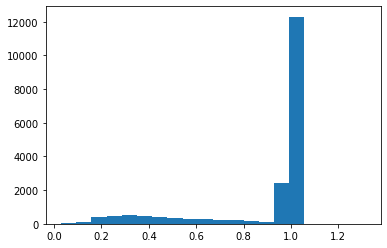

In [103]:
# Look at the distribution of the differences
# Making a histogram of the cosine variable values
plt.hist(cosine_values,bins=20)

In [104]:
print(cosine_values.describe())

count    18827.000000
mean         0.882293
std          0.244810
min          0.029034
25%          0.987092
50%          0.997581
75%          1.003549
max          1.314096
Name: cosine_dist, dtype: float64


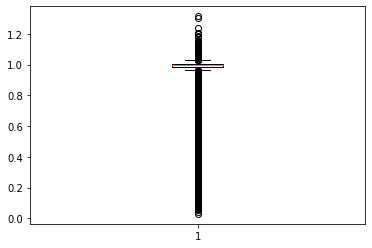

In [105]:
# As shown in the statistics for the cosine values
# The average difference between the Q and A vectors is 0.85 with std of 0.29
plt.boxplot(cosine_values)
plt.show()

In [112]:
food.head()

,asin,question,answer,words in question,words in answer,cosine_dist
0,9742356831,What is the heat of this compared to the yello...,I think that the yellow is the most mild. The ...,13,23,1.008370
1,9742356831,Is there MSG in it?,No MSG in Mae Ploy curry pastes.,5,7,1.019712
2,9742356831,what are the ingredients exactly in this produ...,The ingredients are listed in the description!,9,7,1.008251
3,9742356831,How important is the expiraci&oacute;n date on...,I never pay attention to it myself. The ingred...,10,22,0.540793
4,9742356831,"The product description says 14 oz., but the p...",We bought the 14oz for just under $5.,20,8,0.997320


In [113]:
# How many questions receive answers below limit?
limit = 0.75
# Limit determined from best practice of other comparisons

wrong_answer_count = food['cosine_dist'][abs(food['cosine_dist'])<limit].count()
right_answer_count = food['cosine_dist'][abs(food['cosine_dist'])>=limit].count()
# Print percentage of potential wrong answers
print("If correctness of answer is based on cosine distance less than: ", limit)
print("Potential wrong answer count: ",wrong_answer_count)
print("Potential right answer count: ",right_answer_count)
print("Potential wrong answer percentage: ",100*wrong_answer_count/(wrong_answer_count+right_answer_count))

If correctness of answer is based on cosine distance less than:  0.75
Potential wrong answer count:  3602
Potential right answer count:  15225
Potential wrong answer percentage:  19.13209751951984


In [116]:
# Does this account for Yes answers?
yes_answers = food[(food['answer'].str.lower()=='yes') | (food['answer'].str.lower()=='yes.')]
yes_count_right = yes_answers['cosine_dist'][abs(yes_answers['cosine_dist'])>=limit].count()
yes_count_wrong = yes_answers['cosine_dist'][abs(yes_answers['cosine_dist'])<limit].count()
print("Yes answers with measure above limit: ",yes_count_right)
print("Yes answers with measure below limit: ",yes_count_wrong)
print('\nDistribution of coine_dist for YES answers',yes_answers['cosine_dist'].describe())


Yes answers with measure above limit:  378
Yes answers with measure below limit:  0

Distribution of coine_dist for YES answers count    378.000000
mean       0.998924
std        0.006541
min        0.978300
25%        0.994942
50%        0.999168
75%        1.003317
max        1.017830
Name: cosine_dist, dtype: float64


In [118]:
# Does this account for No answers?
no_answers = food[(food['answer'].str.lower()=='no') | (food['answer'].str.lower()=='no.')]
no_count_right = no_answers['cosine_dist'][abs(no_answers['cosine_dist'])>=limit].count()
no_count_wrong = no_answers['cosine_dist'][abs(no_answers['cosine_dist'])<limit].count()
print("NO answers with measure above limit: ",no_count_right)
print("NO answers with measure below limit: ",no_count_wrong)
print('\nDistribution of coine_dist for YES answers',no_answers['cosine_dist'].describe())

NO answers with measure above limit:  200
NO answers with measure below limit:  0

Distribution of coine_dist for YES answers count    200.000000
mean       1.001232
std        0.006833
min        0.980374
25%        0.996913
50%        1.001099
75%        1.006042
max        1.022150
Name: cosine_dist, dtype: float64


# Topic Modeling
What topics are the customers asking for in the models?  Use Topic Modeling to identify the topics

In [136]:
# Import needed libraries
from gensim.corpora.dictionary import Dictionary
from gensim.models.tfidfmodel import TfidfModel
from gensim.similarities import SparseMatrixSimilarity

In [131]:
print(question_phrases[:5])

[['what', 'is', 'the', 'heat', 'of', 'this', 'compared', 'to', 'the', 'yellow', 'and', 'red', 'curry'], ['is', 'there', 'msg', 'in', 'it'], ['what', 'are', 'the', 'ingredients', 'exactly', 'in', 'this', 'product', 'thanks'], ['how', 'important', 'is', 'the', 'expiraci', 'oacute', 'n', 'date', 'on', 'this', 'curry', 'paste'], ['the', 'product', 'description', 'says', 'but', 'the', 'picture', 'shows', 'the', 'lb', 'oz', 'version', 'which', 'is', 'it', 'thanks']]


In [132]:
# create a dictionary from the questions 
dictionary = Dictionary(question_phrases)

In [133]:
# Create a gensim corpus
# This ia bag of words for the text in the format (token_id, token_count) 2 tuples
bow_corpus = [dictionary.doc2bow(token) for token in question_phrases]
print(bow_corpus)

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 2), (8, 1), (9, 1), (10, 1), (11, 1)], [(4, 1), (12, 1), (13, 1), (14, 1), (15, 1)], [(7, 1), (8, 1), (10, 1), (12, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1)], [(2, 1), (4, 1), (7, 1), (8, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1)], [(4, 1), (7, 3), (13, 1), (19, 1), (20, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1), (36, 1), (37, 1)], [(0, 1), (2, 2), (4, 1), (5, 1), (6, 1), (7, 2), (8, 1), (16, 1), (19, 1), (37, 1), (38, 1), (39, 1), (40, 1), (41, 2), (42, 1), (43, 1), (44, 1), (45, 1), (46, 1), (47, 1), (48, 1)], [(8, 1), (13, 1), (19, 1), (34, 1), (38, 1), (41, 1), (47, 1), (49, 1), (50, 1), (51, 1), (52, 1), (53, 1), (54, 1), (55, 1), (56, 1), (57, 1), (58, 1), (59, 1), (60, 2), (61, 1), (62, 1), (63, 1), (64, 1)], [(6, 1), (7, 2), (10, 1), (12, 1), (16, 1), (18, 1), (51, 1), (57, 1), (65, 1)], [(50, 1), (66, 1), (67, 1), (68, 1)], [(67, 1), (69, 1), (70, 1), (

In [134]:
# To understand tuples better, print out in better format
[[(dictionary[i], freq) for i, freq in doc] for doc in bow_corpus[:3]]

[[('and', 1),
  ('compared', 1),
  ('curry', 1),
  ('heat', 1),
  ('is', 1),
  ('of', 1),
  ('red', 1),
  ('the', 2),
  ('this', 1),
  ('to', 1),
  ('what', 1),
  ('yellow', 1)],
 [('is', 1), ('in', 1), ('it', 1), ('msg', 1), ('there', 1)],
 [('the', 1),
  ('this', 1),
  ('what', 1),
  ('in', 1),
  ('are', 1),
  ('exactly', 1),
  ('ingredients', 1),
  ('product', 1),
  ('thanks', 1)]]

# TF-IDF with Gensim

Building a TF-IDF model using gensim model. 
The tf-idf model transforms vectors from the bag-of-words 
to a vectors where the frequency counts 
are weighted according to the rarity of each word in the corpus.

tfidf is a read-only object that can be used to convert a vector from a previous 
form (bag-of-words integer counts) to new form 

In [135]:
# Initialize model
tfidf = TfidfModel(bow_corpus) 
# Apply transformation to the entire corpus
corpus_tfidf = tfidf[bow_corpus] 

In [141]:
# Apply the model to the document:
corpus_tfidf[1]

[(4, 0.12582947174710515),
 (12, 0.22147660764187926),
 (13, 0.22433258816483137),
 (14, 0.8245420805317722),
 (15, 0.45268123843041475)]

In [143]:
# The most relevant term is 14 followed by 15
# Find these terms
print("Top term: : ",dictionary[14])
print("2nd highest term: : ",dictionary[15])

Top term: :  msg
2nd highest term: :  there


In [147]:
# Find the closest distance between the sparse vectors
index = SparseMatrixSimilarity(corpus_tfidf, num_features = len(dictionary))
query_doc = food['question'].split()
query_bow = dictionary.doc2bow(query_doc)

sims = index[corpus_tfidf[1]]
result = list(enumerate(sims1))
[x for x in result if x[1] > 0]

AttributeError: 'Series' object has no attribute 'split'

## Apply BERT to questions and answers
Bidirectional Encoder Representations from Transformers
Found at: https://www.blog.google/products/search/search-language-understanding-bert/
According to the site "BERT models can therefore consider the full context of a word by looking at the words that come before and after it"
Must include all stopwords when applying BERT models

In [ ]:
# For DistilBERT:  lighter version better for running on local computer
import transformers as ppb
model_class, tokenizer_class, pretrained_weights = (ppb.DistilBertModel, ppb.DistilBertTokenizer, 'distilbert-base-uncased')

# Load pretrained model/tokenizer
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights)

In [ ]:
# BERT wants to process all lines at once, and they must be same length
# Padding question embeddings so that each line is same length
max_q_len = 0
for q in question_embeddings:
    if len(q) > max_q_len:
        max_q_len = len(q)

q_padded = np.array([q + [0]*(max_q_len-len(q)) for q in question_embeddings])
# Masking to point to areas with non zero values
attention_q_mask = np.where(q_padded != 0, 1, 0)


# Padding answer embeddings so that each line is same length
max_a_len = 0
for a in answer_embeddings:
    if len(a) > max_a_len:
        max_a_len = len(a)

a_padded = np.array([a + [0]*(max_a_len-len(a)) for a in question_embeddings])
# Masking to point to areas with non zero values
attention_a_mask = np.where(a_padded != 0, 1, 0)

In [ ]:
# Run the BERT Model
input_q_ids = torch.tensor(q_padded)  
attention_q_mask = torch.tensor(attention_q_mask)

with torch.no_grad():
    last_hidden_states = model(input_q_ids, attention_mask=attention_q_mask)

In [ ]:
# clean the phrase by removing non letters and lower case, remove stop words on request
def clean_phrase(phrase, stopwords=False):
    phrase = phrase.lower().strip()
    phrase = re.sub(r'[^a-z0-9\s]','',phrase)
    
    if stopwords:
        phrase = remove_stopwords(phrase)
    return phrase

# call cleaned for entire dataframe for one feature column and return list of words
def clean_all(df,feature,stopwords=False):
    column = df[[feature]]
    cleaned = []
    for index,row in df.iterrows():
        cleaned_val = clean_phrase(row[feature],stopwords)
        cleaned.append(cleaned_val)
    return cleaned


questions_cleaned = clean_all(food,'question',stopwords=False)
print("Count of questions: ",len(questions_cleaned))

answers_cleaned = clean_all(food,'answer',stopwords=False)
print("\nTop 20 Answer words: \n",answer_words[:20])
print("Count of answers: ",len(answers_cleaned))